<a href="https://colab.research.google.com/github/nicha1997/Data-Analytics-for-Business/blob/main/ARIMA_Model_for_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
## Load the dataset, set the index column to the first column and parse the dates.
train_data = pd.read_csv(r'./Downloads/set.csv', index_col=0, parse_dates=True)
print(train_data)

            store1item1  store1item2  store1item3  store1item4  store1item5  \
date                                                                          
2013-01-01           13           33           15           10           11   
2013-01-02           11           43           30           11            6   
2013-01-03           14           23           14            8            8   
2013-01-04           13           18           10           19            9   
2013-01-05           10           34           23           12            8   
...                 ...          ...          ...          ...          ...   
2017-12-27           14           55           26           16            6   
2017-12-28           19           50           21           20           15   
2017-12-29           15           50           38           25           17   
2017-12-30           27           56           27           19           22   
2017-12-31           23           67           29   

In [ ]:
train_data.head()

,store1item1,store1item2,store1item3,store1item4,store1item5,store1item6,store1item7,store1item8,store1item9,store1item10,...,store10item41,store10item42,store10item43,store10item44,store10item45,store10item46,store10item47,store10item48,store10item49,store10item50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


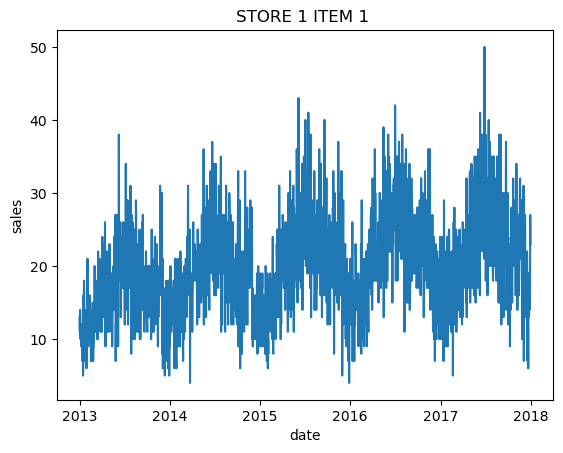

In [ ]:
train_dataS1 = train_data['store1item1'] ## Select the data for 'store1item1' for further analysis.
plt.plot(train_dataS1)
plt.xlabel('date')
plt.ylabel('sales')
plt.title('STORE 1 ITEM 1 ')
plt.show()

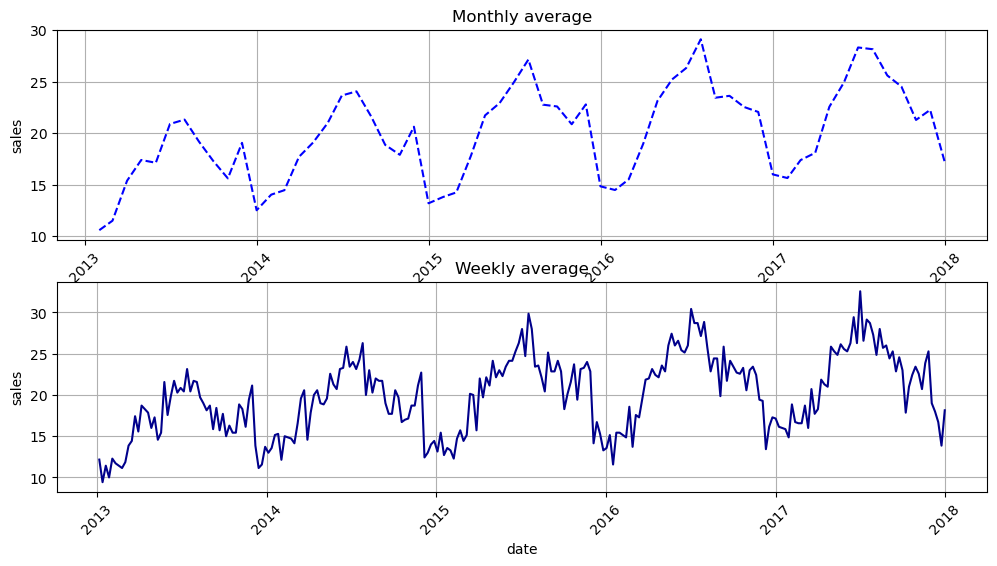

In [ ]:
plt.figure(figsize = (12, 6)) # Plot the monthly average sales of 'store1item1' using monthly frequency.
plt.subplot(2,1,1)
plt.plot(train_dataS1.groupby(pd.Grouper(freq = 'ME')).mean(), color = 'blue', linestyle = '--')
plt.xlabel('date')
plt.ylabel('sales')
plt.grid(True)
plt.xticks(rotation = 45)
plt.title('Monthly average')

plt.subplot(2,1,2) # Plot the weekly average sales of 'store1item1'.
plt.plot(train_dataS1.groupby(pd.Grouper(freq = 'W')).mean(), color = 'darkblue', linestyle = '-')
plt.xlabel('date')
plt.ylabel('sales')
plt.grid(True)
plt.title('Weekly average')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# Assuming train_dataS1 has a DateTimeIndex
train07 = train_dataS1['2013':'2016']  # Select data from 2013 to 2016
foc03 = train_dataS1['2017':]  # Select data from 2017 onwards for forecasting

print(train07)
print(foc03)

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2016-12-27    10
2016-12-28    16
2016-12-29    21
2016-12-30    24
2016-12-31    14
Name: store1item1, Length: 1461, dtype: int64
date
2017-01-01    19
2017-01-02    15
2017-01-03    10
2017-01-04    16
2017-01-05    14
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: store1item1, Length: 365, dtype: int64


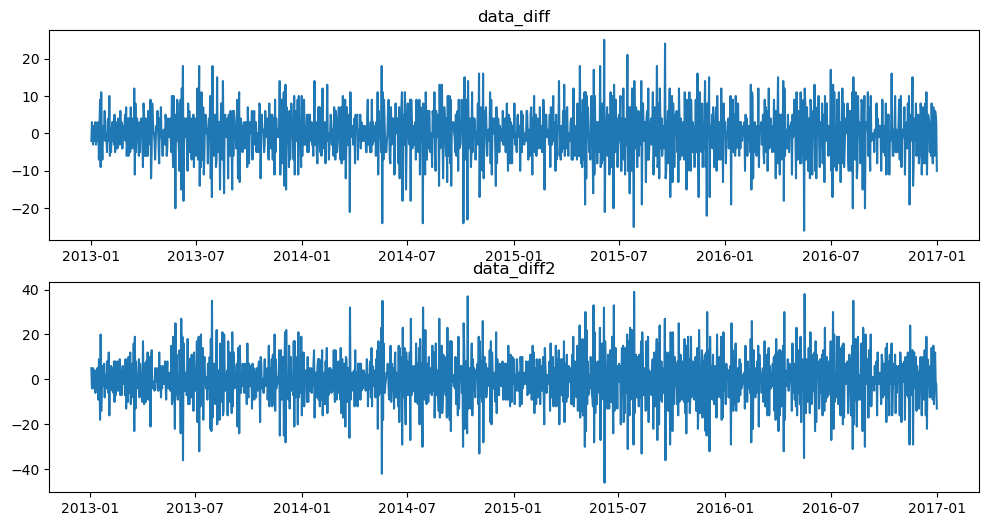

In [ ]:
data_diff = train07.diff() # Calculate the first difference of the training data to make it stationary and drop any missing values.
data_diff = data_diff.dropna()

data_diff2 = data_diff.diff() # Calculate the second difference of the training data and drop any missing values.
data_diff2 = data_diff2.dropna()

plt.figure(figsize = (12, 6))
plt.subplot(2,1,1)
plt.plot(data_diff)
plt.title('data_diff')
plt.subplot(2,1,2)
plt.plot(data_diff2)
plt.title('data_diff2')
plt.show()

In [ ]:
#Testing to check if the time series is stationary.
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
adf_result = adfuller(data_diff)

print('ADF Statistic:', adf_result[0]) # Print the ADF test statistic, p-value, and critical values.
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

lb_result = acorr_ljungbox(data_diff, lags=20) # Perform Ljung-Box test to check for autocorrelation in the data.
print("Ljung-Box result：", lb_result)

ADF Statistic: -13.70280280047344
p-value: 1.2802290363073066e-25
Critical Value (1%): -3.434899302257815
Critical Value (5%): -2.8635492080466607
Critical Value (10%): -2.567839687982253
Ljung-Box result：        lb_stat     lb_pvalue
1   265.897926  8.891259e-60
2   270.424111  1.897363e-59
3   271.002006  1.873623e-58
4   271.757187  1.333559e-57
5   272.648139  7.554424e-57
6   280.349161  1.322690e-57
7   380.323746  3.941823e-78
8   391.106653  1.494835e-79
9   393.999804  2.610727e-79
10  394.013757  1.768384e-78
11  394.990249  7.080474e-78
12  395.856616  2.852599e-77
13  404.956582  2.007044e-78
14  489.320748  1.698779e-95
15  493.838390  1.135971e-95
16  494.411436  5.027159e-95
17  499.610068  2.285866e-95
18  499.774039  1.163986e-94
19  499.919064  5.810273e-94
20  507.438833  8.055609e-95


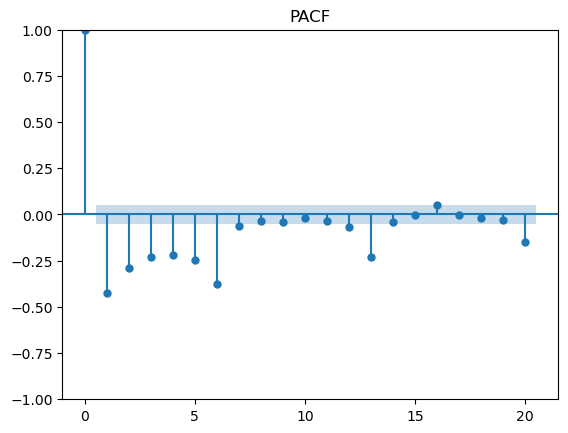

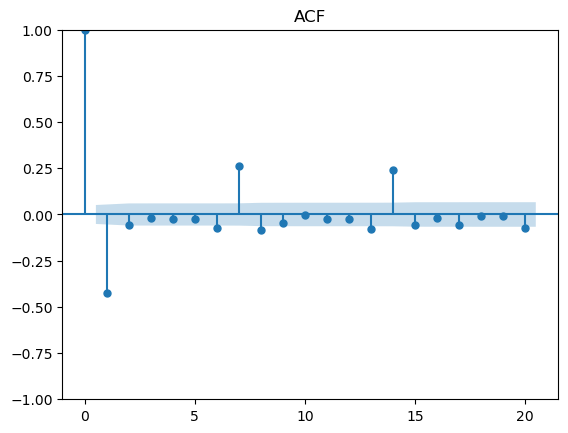

In [ ]:
#ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(data_diff,lags = 20)
plt.title('PACF')
plt.show()

acf = plot_acf(data_diff, lags = 20)
plt.title('ACF')
plt.show()

In [ ]:
# Forecast and evaluate the model on the forecast data set foc03.
history = [x for x in train07]
prediction_foc03 = list()
for t in range(len(foc03)):
    model = ARIMA(history,order=(6,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    prediction_foc03.append(int(output[0]))
    history.append(foc03.iloc[t])

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

error = mse(foc03, prediction_foc03)
rmse = np.sqrt(error)
mae = mean_absolute_error(foc03, prediction_foc03)
mape = mean_absolute_percentage_error(foc03, prediction_foc03)
r2 = r2_score(foc03, prediction_foc03)

print('Mean Squared Error = {}'.format(error))
print('Root Mean Squared Error = {}'.format(rmse))
print('Mean Absolute Error = {}'.format(mae))
print('Mean Absolute Percentage Error = {}'.format(mape))
print('R² = {}'.format(r2))

Mean Squared Error = 31.797260273972604
Root Mean Squared Error = 5.638905946544295
Mean Absolute Error = 4.465753424657534
Mean Absolute Percentage Error = 0.22776933523091325
R² = 0.34051952152135756


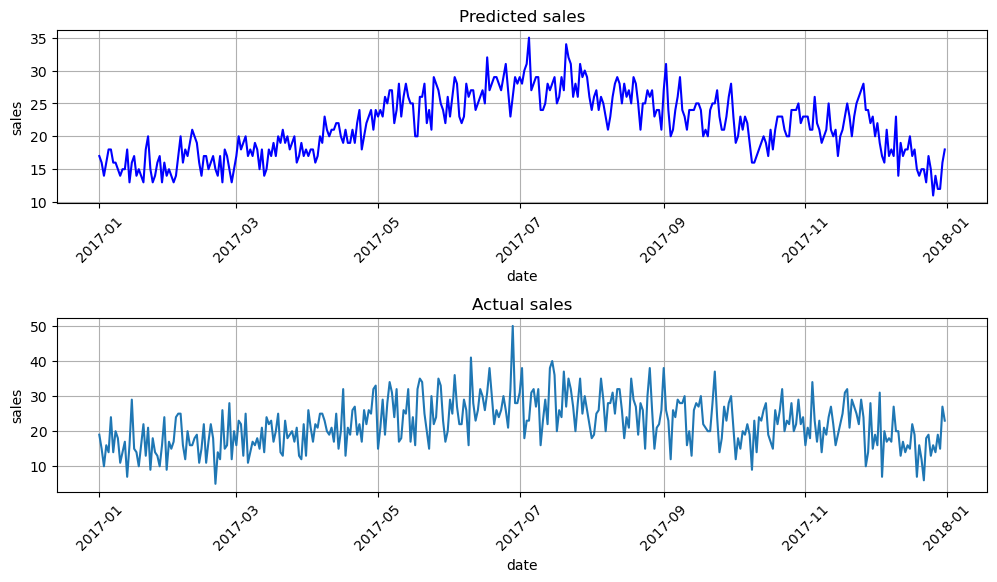

In [ ]:
# Plot the Predicted sales data and Predicted sales data.
plt.figure(figsize = (12, 6))
plt.subplots_adjust(hspace=0.66)
plt.subplot(2,1,1)
plt.plot(foc03.index, prediction_foc03,color='blue')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Predicted sales')
plt.grid(True)
plt.xticks(rotation = 45)

plt.subplot(2,1,2)
plt.plot(foc03)
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Actual sales')
plt.grid(True)
plt.xticks(rotation=45)


plt.show()

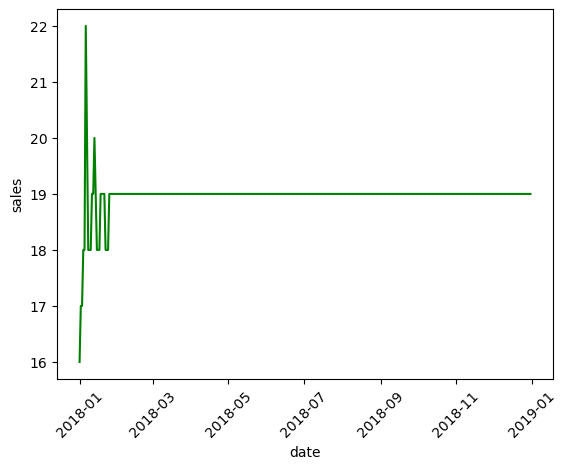

In [ ]:
# Use ARIMA model to forecast 365 days ahead in a rolling-window fashion.
history = [x for x in train_dataS1]
prediction_test = list()
for t in range(365):
    model = ARIMA(history,order=(6,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    prediction_test.append(int(output[0]))
    history.append(output[0])

dates = pd.date_range('1/1/2018',periods=365,freq='D')
prediction_test_df = pd.DataFrame(prediction_test,index=dates)
prediction_test_df.columns = ['sales']

plt.plot(prediction_test_df,color='green')
plt.xlabel('date')
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.show()

In [ ]:
complete_submission = pd.DataFrame({'date': pd.date_range('2018-01-01', periods=365, freq='D')}) # Create a complete submission DataFrame containing date and predicted sales.

all_predictions = {}

for column in train_data.columns:  # Generate predictions for each column (each store-item combination) in the dataset.
    print(f"Processing column: {column}")
    train_dataS1 = train_data[column].astype('float64')
    history = [x for x in train_dataS1]
    prediction_test = list()
    for t in range(365):
        model = ARIMA(history, order=(6, 1, 0))
        model_fit = model.fit()
        output = model_fit.forecast()
        prediction_test.append(int(output[0]))
        history.append(output[0])

    all_predictions[column] = prediction_test

predictions_df = pd.DataFrame.from_dict(all_predictions)

complete_submission = pd.concat([complete_submission, predictions_df], axis=1)

complete_submission.to_csv('NO_standard_data610.csv', index=False)

print(complete_submission.head())

Processing column: store1item1
Processing column: store1item2
Processing column: store1item3
Processing column: store1item4
Processing column: store1item5
Processing column: store1item6
Processing column: store1item7
Processing column: store1item8
Processing column: store1item9
Processing column: store1item10
Processing column: store1item11
Processing column: store1item12
Processing column: store1item13
Processing column: store1item14
Processing column: store1item15
Processing column: store1item16
Processing column: store1item17
Processing column: store1item18
Processing column: store1item19
Processing column: store1item20
Processing column: store1item21
Processing column: store1item22
Processing column: store1item23
Processing column: store1item24
Processing column: store1item25
Processing column: store1item26
Processing column: store1item27
Processing column: store1item28
Processing column: store1item29
Processing column: store1item30
Processing column: store1item31
Processing column